# **Direct Sampling : Inverse Transform Sampling**

From uniform [0,1] get another law 

- Exponential 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

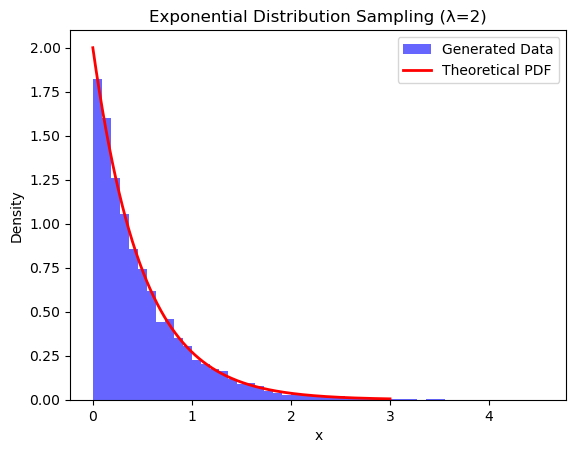

In [1]:


# Parameters
lambda_val = 2  # Rate parameter for Exponential(λ)

# Generate uniform random numbers
U = np.random.uniform(0, 1, 10000)

# Apply inverse transformation
X = -np.log( U) / lambda_val

# Plot histogram to compare with theoretical PDF
plt.hist(X, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")

# Plot theoretical density function
x_vals = np.linspace(0, 3, 1000)
pdf = lambda_val * np.exp(-lambda_val * x_vals)
plt.plot(x_vals, pdf, 'r', lw=2, label="Theoretical PDF")

plt.xlabel("x")
plt.ylabel("Density")
plt.title("Exponential Distribution Sampling (λ=2)")
plt.legend()
plt.show()


- Bernouilli

In [7]:
#see geometric with intervals too
p=0.5
U = np.random.uniform(0, 1, 10000)
X = (U < p).astype(int)

unique, counts = np.unique(X, return_counts=True)
print(unique,counts)


[0 1] [4988 5012]


- Pareto

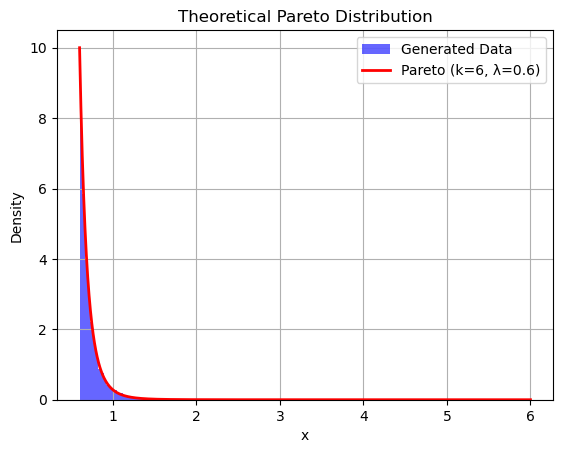

In [23]:
from scipy.stats import pareto
lmb=0.6
k=6
U = np.random.uniform(0, 1, 10000)
X = lmb/U**(1/k)

# Plot histogram to compare with theoretical PDF
plt.hist(X, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")

# Generate x values for the theoretical Pareto distribution
x_vals = np.linspace(lmb, lmb*10 , 1000)
pdf = pareto.pdf(x_vals, k, scale=lmb)

# Plot the theoretical Pareto distribution

plt.plot(x_vals, pdf, 'r-', lw=2, label=f'Pareto (k={k}, λ={lmb})')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Theoretical Pareto Distribution')
plt.legend()
plt.grid()
plt.show()

- Laplace

[ 0.         -3.79452075 -2.02299297 ...  0.         -2.55679624
  0.        ]


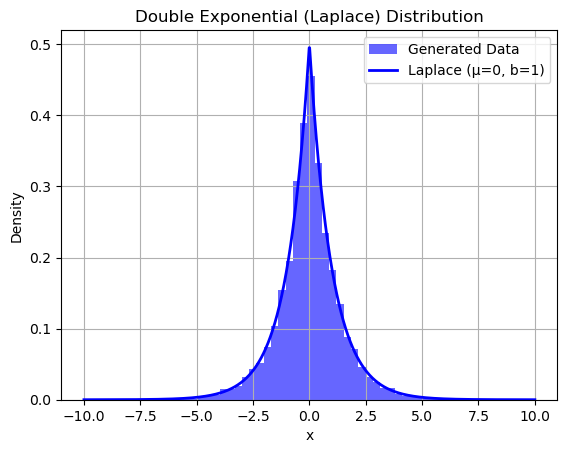

In [22]:
U = np.random.uniform(0, 1, 10000)

from scipy.stats import laplace
left=np.log(2*U)*(U <= 0.5).astype(int)
right=-np.log(-2*(U-1))*(U > 0.5).astype(int)
print(left)
for i,(el_x,el_y) in enumerate(zip(left,right)):
    if el_x==0:
        left[i]=right[i]
  
plt.hist(left, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")   

x = np.linspace(-10, 10, 1000)
pdf = laplace.pdf(x, loc=0, scale=1)


plt.plot(x, pdf, 'b-', lw=2, label=f'Laplace (μ={0}, b={1})')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Double Exponential (Laplace) Distribution')
plt.legend()
plt.grid()
plt.show()

-Laplace with Radamacher

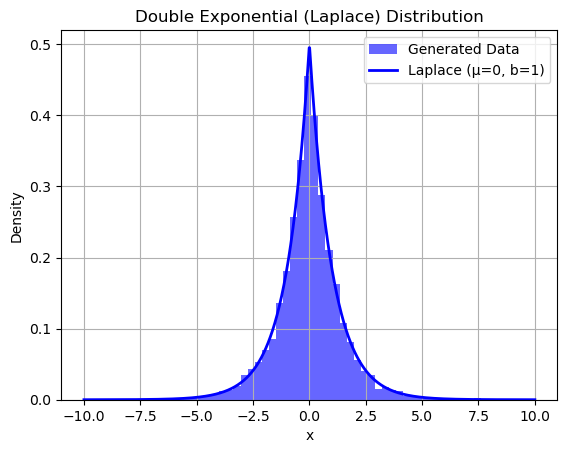

In [23]:
U1 = np.random.uniform(0, 1, 10000)
U2 = np.random.uniform(0, 1, 10000)

#parameters
p=0.5
S = (U1 < p).astype(int)*2-1
Z=-np.log(U2)#exponential


plt.hist(S*Z, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")  
x = np.linspace(-10, 10, 1000)
pdf = laplace.pdf(x, loc=0, scale=1)
plt.plot(x, pdf, 'b-', lw=2, label=f'Laplace (μ={0}, b={1})')
plt.xlabel('x')
plt.ylabel('Density')
plt.title('Double Exponential (Laplace) Distribution')
plt.legend()
plt.grid()
plt.show()
plt.show()

- Normal (Box Muller)

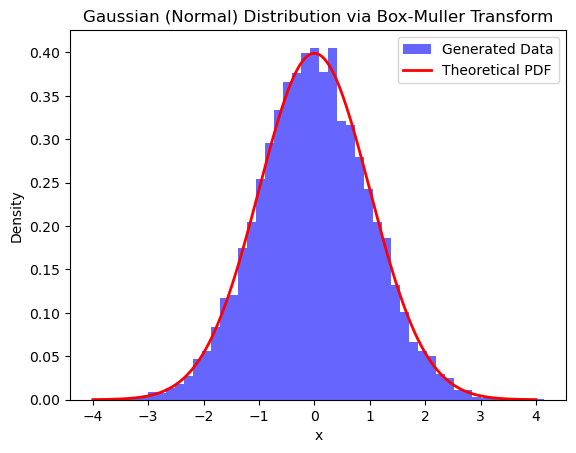

In [22]:
U = np.random.uniform(0, 1, 10000)
V = np.random.uniform(0, 1, 10000)
from scipy.stats import norm
# Apply Box-Muller Transform
X = np.sqrt(-2 * np.log(U)) * np.cos(2 * np.pi * V)
Y = np.sqrt(-2 * np.log(U)) * np.sin(2 * np.pi * V)
plt.hist(X, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")  

# Plot theoretical Gaussian PDF
x_vals = np.linspace(-4, 4, 1000)
pdf = norm.pdf(x_vals, 0, 1)
plt.plot(x_vals, pdf, 'r-', lw=2, label="Theoretical PDF")

# Labels and Title
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Gaussian (Normal) Distribution via Box-Muller Transform")
plt.legend()
plt.show()


- Geometric

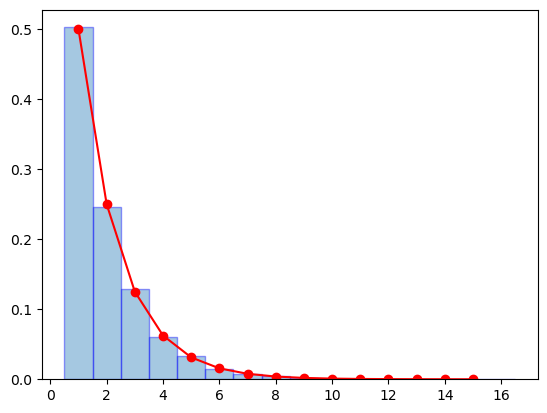

In [ ]:
U = np.random.uniform(0, 1, 10000)
p=0.5
#average down to make discrete and start from 1
X = np.floor(np.log(1 - U) / np.log(1 - p))+1
 
plt.hist(geometric_samples_inverse, bins=np.arange(1, np.max(geometric_samples) + 2) - 0.5,
         density=True, alpha=0.4, edgecolor="blue", label="Inverse Transform Samples")

x = np.arange(1, np.max(X) + 1)
pmf = stats.geom.pmf(x, p)
plt.plot(x, pmf, 'ro-', label="Theoretical Geometric PMF")

plt.show()

- Geometric using the inverse cdf as quantiles with simple conditions when x is finite discrete ( not efficient), instead use unverse transformation

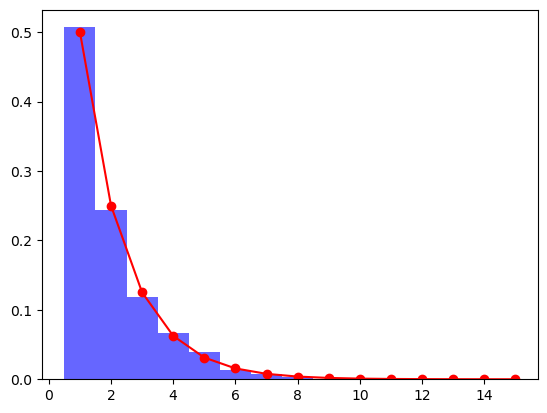

In [ ]:
import numpy as np
import scipy.stats as stats
p=0.5

samples=[]
num_repitions=10**3
for el in range(0,num_repitions):
 U = np.random.uniform(0, 1)
 x=  1
 old_cdf=0
 while True:
     new_cdf=1-(1-p)**x#this is cdf so no need to sum, already sumed
     if (U<=new_cdf and U>old_cdf):#exactly cdf quantiles implementation generalised inverse
         break
     x=x+1
     old_cdf=new_cdf
 samples.append(x)
 

plt.hist(samples, bins=np.arange(1, np.max(samples) + 2) - 0.5, density=True, alpha=0.6, color='b', label="Generated Data") 


x = np.arange(1, np.max(X) + 1)
pmf = stats.geom.pmf(x, p)
plt.plot(x, pmf, 'ro-', label="Theoretical Geometric PMF")
plt.show()
   

- Poisson

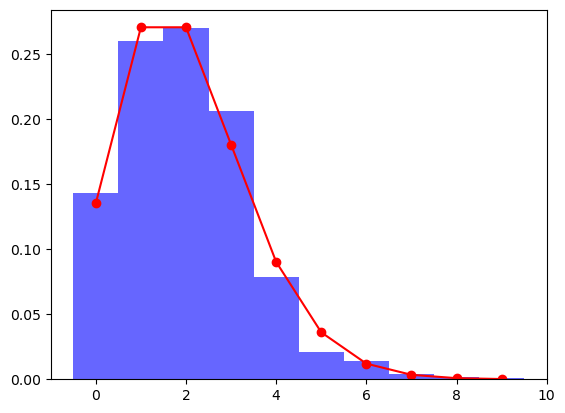

In [93]:
import numpy as np
import scipy.stats as stats
lam=2

samples=[]
num_repitions=10**3
for el in range(0,num_repitions):
 U = np.random.uniform(0, 1)
 x=  0#has to be in order from 0 to inf
 old_cdf=0
 while True:
     new_cdf=old_cdf+np.exp(-lam)*(lam**x)/math.factorial(x)#this is pdf, no cdf!! so sum probability
     if (U<=new_cdf and U>old_cdf):#exactly cdf quantiles implementation generalised inverse
         break
     x=x+1
     old_cdf=new_cdf
 samples.append(x)
 

plt.hist(samples, bins=np.arange(np.max(samples) + 2) - 0.5, density=True, alpha=0.6, color='b', label="Generated Data") 

# Generate x values for PMF and CDF
x = np.arange(0, np.max(samples) + 1)

# Compute Poisson PMF
pmf = stats.poisson.pmf(x, mu=lam)
plt.plot(x, pmf, 'ro-', label="Theoretical Geometric PMF")

plt.show()
   

- Binomial

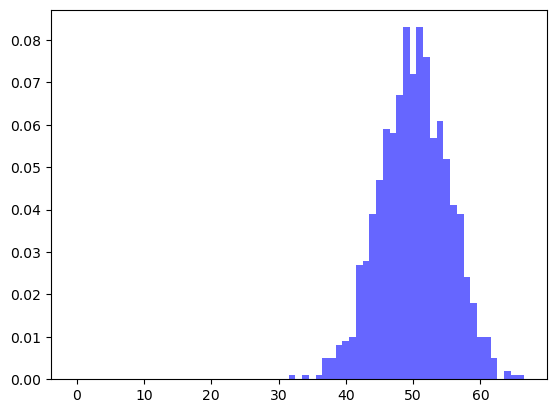

In [94]:
import numpy as np
import scipy.stats as stats
p=0.5
n=100
samples=[]
num_repitions=10**3
for el in range(0,num_repitions):
 U = np.random.uniform(0, 1)
 x=  0#has to be in order from 0 to inf
 old_cdf=0
 while True:

     new_cdf=old_cdf+math.comb(n, x) * (p**x) * ((1 - p)**(n - x))#this is pdf, no cdf!! so sum probability
     if (U<=new_cdf and U>old_cdf):#exactly cdf quantiles implementation generalised inverse
         break
     x=x+1
     old_cdf=new_cdf
 samples.append(x)
 

plt.hist(samples, bins=np.arange(np.max(samples) + 2) - 0.5, density=True, alpha=0.6, color='b', label="Generated Data") 

plt.show()
   

- Weilbul

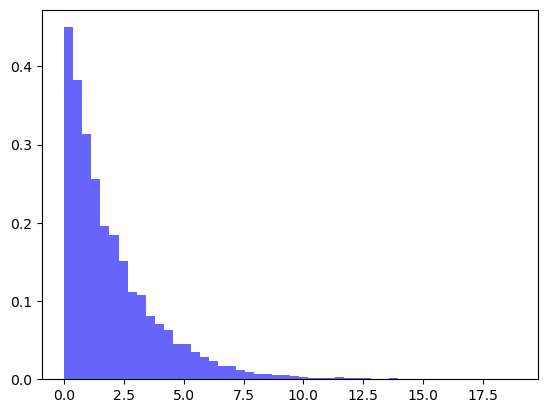

In [98]:
B=2
a=1
U = np.random.uniform(0, 1, 10000)
X = -B*(np.log(U))**(1/a)

# Plot histogram to compare with theoretical PDF
plt.hist(X, bins=50, density=True, alpha=0.6, color='b', label="Generated Data")
plt.show()

- Discrete uniform on K

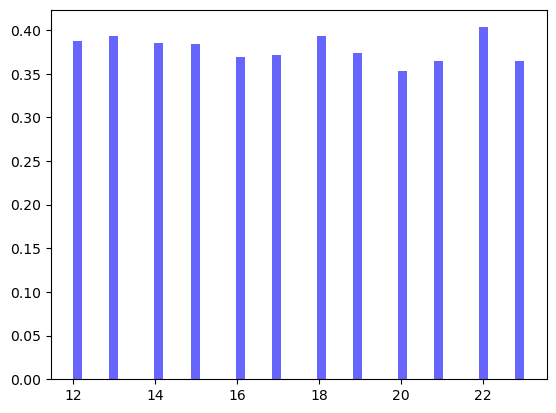

In [7]:

U = np.random.uniform(0, 1, 10000)


a=12
b=23
plt.hist(np.floor((b-a+1)*U-1+a)+1, bins=50, density=True, alpha=0.6, color='b', label="Generated Data") 
plt.show()

- Logistic

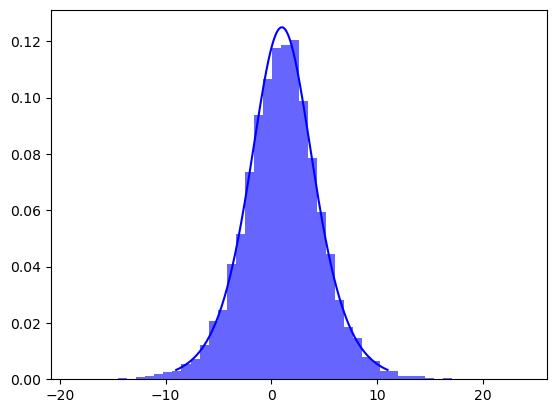

In [11]:
import scipy.stats as stats
U = np.random.uniform(0, 1, 10000)


a=1
b=2
X=a+b*np.log(U/(1-U))
# Compute PDF and CDF using scipy.stats.logistic
x = np.linspace(a - 5*b, a + 5*b, 1000)
pdf = stats.logistic.pdf(x, loc=a, scale=b)
plt.hist(X, bins=50, density=True, alpha=0.6, color='b', label="Generated Data") 
plt.plot(x, pdf, label="PDF", color="blue")
plt.show()

# Rejection

- Standard rejection algorithm

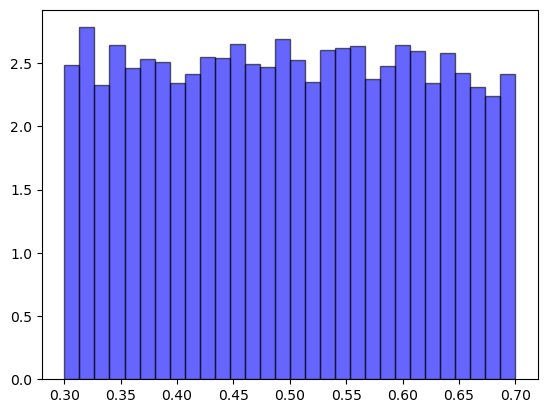

In [25]:

# Define the desired interval B = [0.3, 0.7] over uniform distribution
lower_bound = 0.3
upper_bound = 0.7

# Generate samples using rejection sampling
samples = []
while len(samples) < 10000:  # Generate 10,000 valid samples ( A)
    X = np.random.uniform(0, 1)  # Sample from U(0,1)
    if lower_bound <= X <= upper_bound:  # Accept only if within B
        samples.append(X)

# Plot histogram of accepted samples
plt.hist(samples, bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.show()


- Box-Muller with rejection

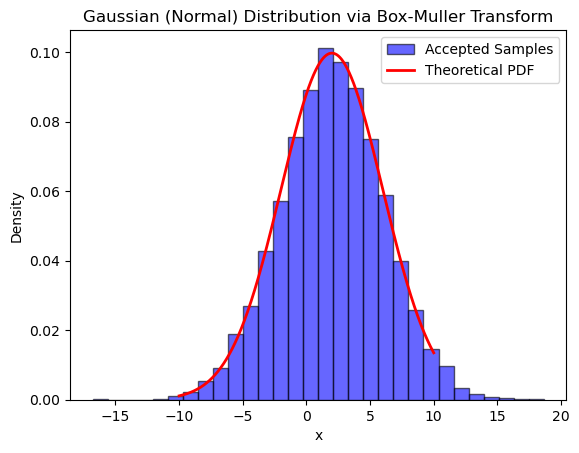

In [18]:

from scipy.stats import norm
# Generate samples using rejection sampling without sin cos
sigma=4
mu=2
samples_x = []
samples_y = []
while len(samples_x) < 10000:  # Generate 10,000 valid samples ( A)
    U = np.random.uniform(-1, 1, )
    V = np.random.uniform(-1, 1, )
    S=U**2+V**2
    if S<=1:  # Accept only if within B
        samples_x.append(U*np.sqrt(-2 * np.log(S)/S))
        samples_y.append(V*np.sqrt(-2 * np.log(S)/S))
# Plot histogram of accepted samples mu+sigma*X~N(mu,sigma2)
samples_x = np.array(samples_x) * sigma + mu
plt.hist(samples_x, bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
x_vals = np.linspace(-10, 10, 1000)
pdf = norm.pdf(x_vals, mu, sigma)
plt.plot(x_vals, pdf, 'r-', lw=2, label="Theoretical PDF")

# Labels and Title
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Gaussian (Normal) Distribution via Box-Muller Transform")
plt.legend()
plt.show()
plt.show()


# **Accept-Reject algorithm**

# Target Density

Consider the function

$$
f(x) =  e^{-x^4}
$$

This function is known only up to a multiplicative constant.the pdf given by 

$$
p(x) = \frac{f(x)}{Z},
$$

where

$$
Z = \int_{0}^{\infty} f(x) \, dx.
$$


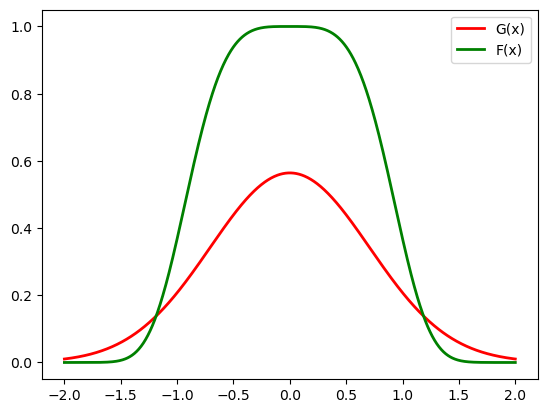

In [2]:

# Target distribution: f(x) ∝ e^(-x^4) estimated with kernel or histograms for example , attention, it is proportional, not pdf of f!!! look after 
def f(x):
    return np.exp(-x**4)

# Proposal distribution: Normal N(0,0.5)
mu=0
sigma2=0.5
def g(x):
    #mu=0, sigma2=0.5
    # return np.exp(-x**2 / 2*0.5) / (np.sqrt(2 * np.pi*0.5))  # Standard Normal PDF, quues have to be higher 
    
    return np.exp(-x**2 / (2*sigma2)) / (np.sqrt(2 * np.pi*sigma2))

#set our event space w
x_vals = np.linspace(-2, 2, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [5]:
#find  M such that M*G(x)>=F(x) so M= sup f/G ( find with max)
M=np.max(f(x_vals)/pdf_g)
M

np.float64(2.275875066329523)

In [6]:
#analytically find M by maximising f/G and then M*=
print(np.sqrt(2 * np.pi*sigma2)*np.exp(1/(16*sigma2**2)))
#analytically find sigma2 by minimising log(M)
sigma2=0.5

2.275875794468747


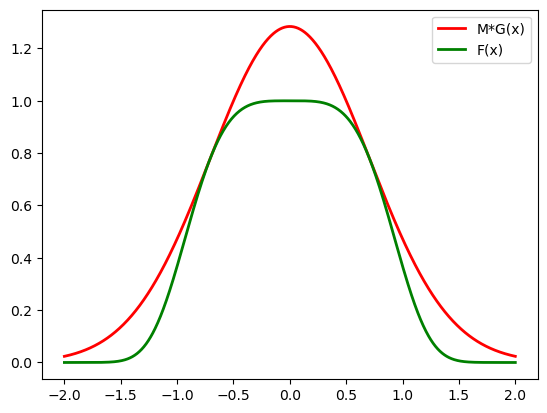

In [7]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
plt.plot(x_vals, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [8]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    V1 = np.random.uniform(-1, 1, )
    V2 = np.random.uniform(-1, 1, )
    S=V1**2+V2**2
    if S<=1:  # x sampled from normal using rejection and box muller , 
         x=V1*np.sqrt(-2 * np.log(S)/S)
         x=x*np.sqrt(sigma2)
        #  or use : x=np.random.normal(0,np.sqrt(sigma2),1)[0].item()
         if U<=f(x)/(M*g(x)):  # Accept-reject algo 
           samples.append(x)

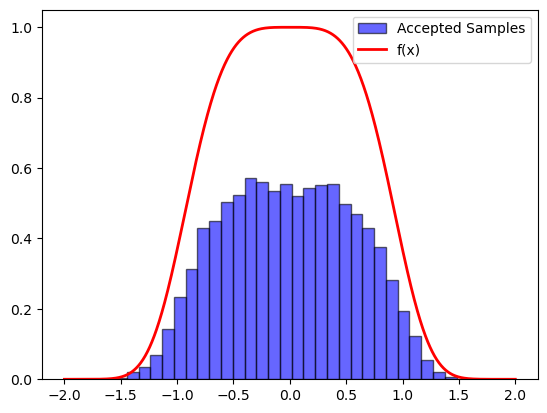

In [9]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f(x_vals), 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()
#normal behaviour as f is not pdf but proportional pdf so find constant Z that will normalise f


In [10]:
from scipy.integrate import quad

Z, error = quad(f, -np.inf, np.inf)
print("Integral of f over (-∞, ∞):", Z,"so since not 1 it is not a pdf so our aim is not divide pdf by this Z")

Integral of f over (-∞, ∞): 1.8128049541109543 so since not 1 it is not a pdf so our aim is not divide pdf by this Z


Integral of f_density over (-∞, ∞): 1.0 ,good!


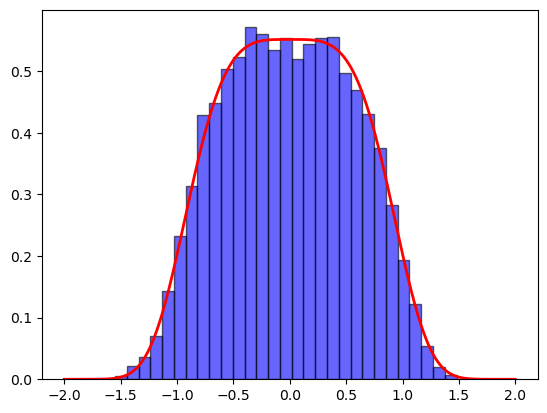

In [11]:
def f_density(x):
    #normalise and it becomes pdf of f
    return np.exp(-x**4)/Z

#verify that f is pdf 
integral, error = quad(f_density, -np.inf, np.inf)
print("Integral of f_density over (-∞, ∞):", integral,",good!")

plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f_density(x_vals), 'r-', lw=2)

# Target Density

Consider the function

$$
f(x) = x^3 \, e^{-x^2/2}, \quad x \ge 0.
$$




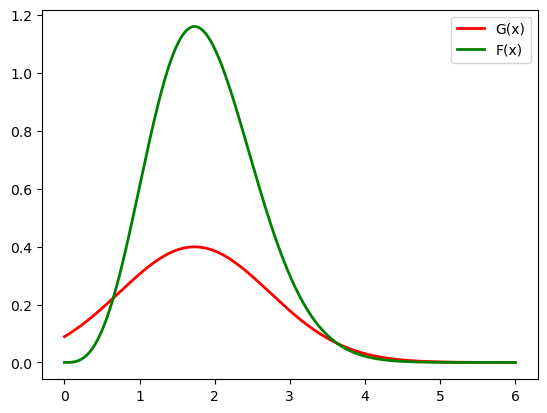

In [32]:
def f(x):
    return x**3*np.exp(-x**2/2)

mu=np.sqrt(3)
sigma2=1.0
# Proposal distribution: Normal N(sqrt3,1)
def g(x):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2)  


#set our event space w
x_vals = np.linspace(0, 6, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

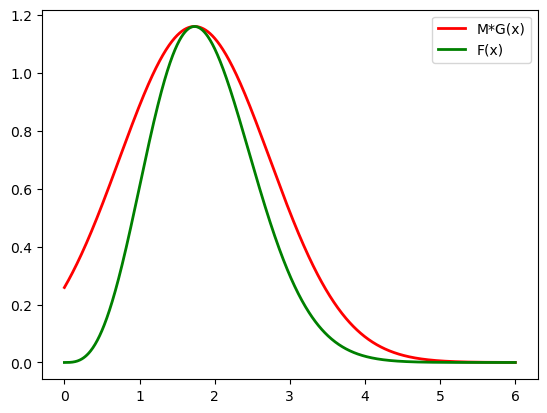

In [33]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
plt.plot(x_vals, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [34]:
#in f(x) select your parameters so that M will be minimal ( here i did adhoc mu=1.75 for f(x))
M

np.float64(2.9062229131299357)

In [35]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    V1 = np.random.uniform(-1, 1, )
    V2 = np.random.uniform(-1, 1, )
    S=V1**2+V2**2
    if S<=1:  # x sampled from normal using rejection and box muller , equivalently you can do this : # x=np.random.normal(0,1,1)[0].item() just with library
        x=V1*np.sqrt(-2 * np.log(S)/S)
        x=x+mu
        if U<=f(x)/(M*g(x)):  # Accept-reject algo 
           samples.append(x)

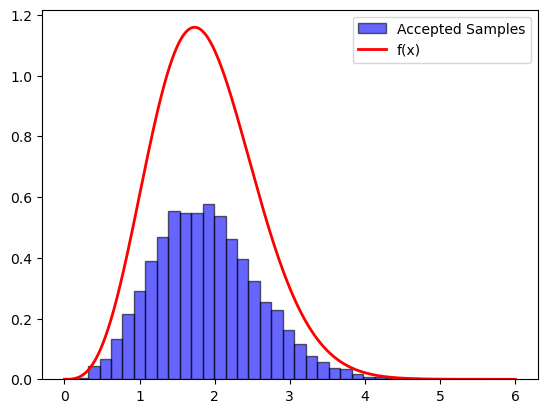

In [36]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f(x_vals), 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()

In [37]:
from scipy.integrate import quad

Z, error = quad(f, 0, np.inf)
print("Integral of f over (0, ∞):", Z,"so since not 1 it is not a pdf so our aim is not divide pdf by this Z")

Integral of f over (0, ∞): 2.0 so since not 1 it is not a pdf so our aim is not divide pdf by this Z


Integral of f_density over (-∞, ∞): 1.0 ,good!


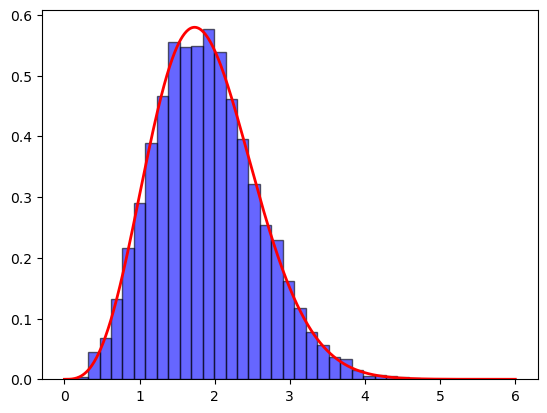

In [38]:
def f_density(x):
    #normalise and it becomes pdf of f
    return x**3*np.exp(-x**2/2)/Z

#verify that f is pdf 
integral, error = quad(f_density, 0, np.inf)
print("Integral of f_density over (-∞, ∞):", integral,",good!")

plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f_density(x_vals), 'r-', lw=2,label="M*G(x)")

F normal g laplace

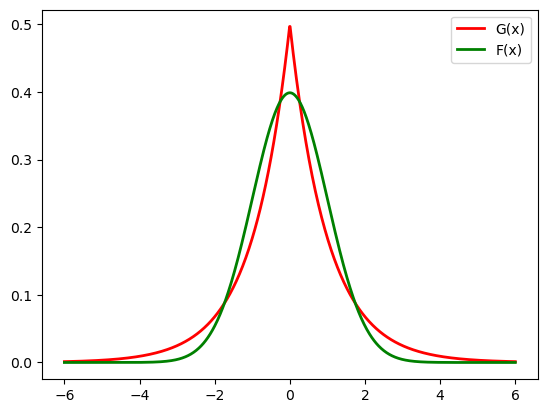

In [67]:

mu=0
sigma2=1

def f(x):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2) 


# Proposal distribution: Normal N(sqrt3,1)
def g(x):
    return 0.5*np.exp(-np.abs(x)) 


#set our event space w
x_vals = np.linspace(-6, 6, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

1.3154833154134895


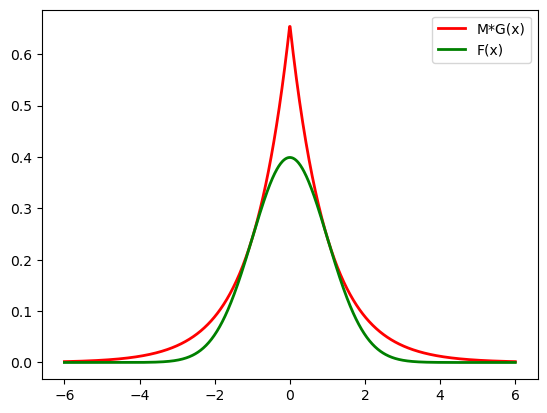

In [70]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
print(M)
plt.plot(x_vals, pdf_g*M, 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

In [71]:
#analytically M=
2*np.exp(0.5)/(np.sqrt(2*np.pi))

np.float64(1.315489246958914)

In [54]:
#implement algo 
samples = []
while len(samples) < 10000: 
    U = np.random.uniform(0, 1, )
    U1 = np.random.uniform(0, 1, )
    U2 = np.random.uniform(0, 1, )
    
#parameters
    p=0.5
    S = np.array((U1 < p)).astype(int)*2-1
    Z=-np.log(U2)#exponential
    x=S*Z
    if U<=f(x)/(M*g(x)):  # Accept-reject algo 
           samples.append(x)

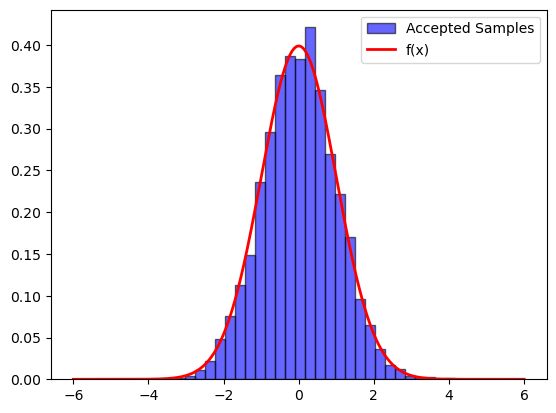

In [55]:
#plot accepted samples with f(x_vals)
plt.hist(np.array(samples), bins=30, density=True, alpha=0.6, color='b', edgecolor='black', label="Accepted Samples")
plt.plot(x_vals, f(x_vals), 'r-', lw=2,label="f(x)")
plt.legend()
plt.show()

In [56]:
from scipy.integrate import quad

Z, error = quad(f, -np.inf, np.inf)
print("Integral of f over (0, ∞):", Z,"good")

Integral of f over (0, ∞): 0.9999999999999998 good


F laplace g normal

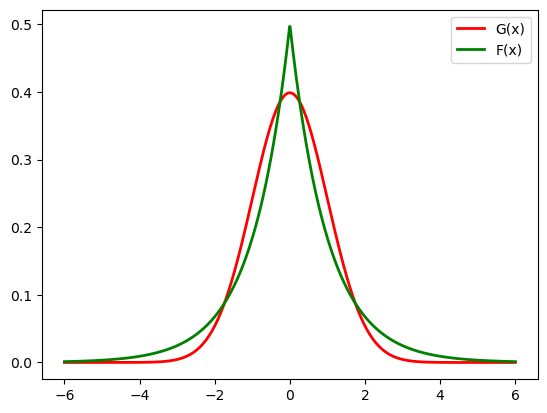

In [73]:

mu=0
sigma2=1

def g(x):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2) 


# Proposal distribution: Normal N(sqrt3,1)
def f(x):
    return 0.5*np.exp(-np.abs(x)) 


#set our event space w
x_vals = np.linspace(-6, 6, 1000)
#g is pdf so you can use this notation 
pdf_g=g(x_vals)

plt.plot(x_vals, pdf_g, 'r-', lw=2,label="G(x)")  # Add label for legend
# 
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()

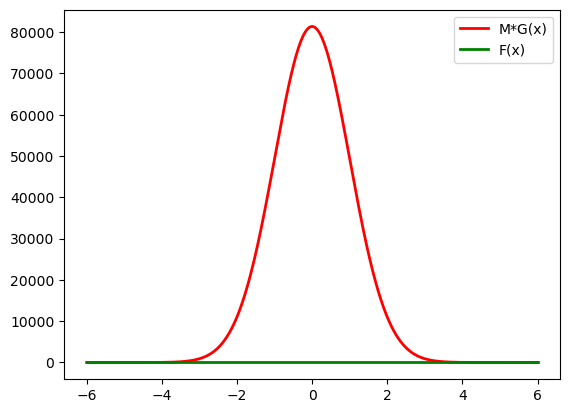

In [81]:
#find minimal M such that M*G(x)>=F(x)
M=np.max(f(x_vals)/pdf_g)
plt.plot(x_vals, pdf_g *M   , 'r-', lw=2,label="M*G(x)")  # Add label for legend
plt.plot(x_vals, f(x_vals), 'g-', lw=2,label="F(x)")
plt.legend()#not possible

In [75]:
(np.sqrt(2 * np.pi) / 2) * np.exp(-0.5) #it is min!!! so can not do this relationship 

np.float64(0.7601734505331403)

In [39]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize, minimize_scalar

In [ ]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import minimize, minimize_scalar


def g(x):
 
    return np.exp(-x**4)


def f(x, mu, sigma):
    return np.exp(-(x-mu)**2 /(2*sigma2)) / np.sqrt(2 * np.pi*sigma2)  


def ratio(x, mu, sigma):
    return g(x) / f(x, mu, sigma)

# ---------------------------
# For fixed (mu, sigma), compute the envelope constant M(mu, sigma)
# defined as the maximum (supremum) of ratio(x, mu, sigma) over x.
#
# Since the domain is the real line, we restrict our search to a wide interval.
# (Here we use a heuristic: L = max(10, |mu| + 5*sigma) ).
# ---------------------------
def compute_M(mu, sigma):
    L = max(10, abs(mu) + 5*sigma)
    # We minimize the negative of the ratio to find its maximum on [-L, L].
    result = minimize_scalar(lambda x: -ratio(x, mu, sigma),
                             bounds=(-L, L), method='bounded')
    if result.success:
        return -result.fun  # maximum value of ratio
    else:
        return np.inf

# ---------------------------
# Now define the “outer” objective function which, given parameters,
# returns the envelope constant M. We will optimize over (mu, log_sigma)
# so that sigma = exp(log_sigma) > 0.
# ---------------------------
def objective(params):
    mu, log_sigma = params
    sigma = np.exp(log_sigma)
    return compute_M(mu, sigma)

# ---------------------------
# Initial guess.
# For our example we expect mu = 0 and sigma = 1/sqrt(2) (so that g and f match up to constant)
# Note: log(1/sqrt(2)) = -0.5 * log(2)
# ---------------------------
init_mu = 0.0
init_sigma = 1 / np.sqrt(2)
init_log_sigma = np.log(init_sigma)
init_params = [init_mu, init_log_sigma]

# ---------------------------
# Optimize the envelope constant over (mu, log_sigma)
# ---------------------------
result = minimize(objective, init_params, method='Nelder-Mead')

# Extract the optimal parameters:
optimal_mu = result.x[0]
optimal_sigma = np.exp(result.x[1])
optimal_M = compute_M(optimal_mu, optimal_sigma)

# ---------------------------
# Report the results
# ---------------------------
print("Optimal proposal parameters for rejection sampling:")
print("  mu     =", optimal_mu)
print("  sigma  =", optimal_sigma)
print("Resulting envelope constant M =", optimal_M)

# ---------------------------
# (Optional) For our example, we know the analytic answer:
# For g(x) = exp(-x^2) and f(x;0,1/sqrt(2)), one has
#   ratio(x) = sqrt(pi) for all x.
# ---------------------------
print("\nAnalytic value (should be close to): M = sqrt(pi) =", np.sqrt(np.pi))


next, optimise for parameters to minimise M 